In [152]:
# Homework 2 libs
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import pickle # for the project

from aa598.hw2_helper import simulate_dynamics
import cvxpy as cp
from cbfax.dynamics import *

# Homework 1 libs
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import aa598.hw1_helper as hw1_helper


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False) # set to False if latex is not set up on your computer


In [153]:
robot = DynamicallyExtendedSimpleCar() # robot dynamics
human = DynamicallyExtendedSimpleCar() # human dynamics

@jax.jit
def obstacle_constraint(state, obstacle, radius):
    return jnp.linalg.norm(state[:2] - obstacle[:2]) - radius


In [154]:
planning_horizon = 25
num_time_steps = 30
num_sqp_iterations = 15
dt = 0.1
t = 0. # this doesn't affect anything, but a value is needed 
radius = 1. # minimum collision distance

v_max = 1.5
v_min = 0.
acceleration_max = 1.0
acceleration_min = -1.0
steering_max = 0.3
steering_min = -0.3

human_control_prediction_noise_limit = 0.25
human_control_prediction_variance = 0.25


In [155]:
xs = cp.Variable([planning_horizon+1, robot.state_dim])  # cvx variable for states
us = cp.Variable([planning_horizon, robot.control_dim])  # cvx variable for controls
slack = cp.Variable(1) # slack variable to make sure the problem is feasible
As = [cp.Parameter([robot.state_dim, robot.state_dim]) for _ in range(planning_horizon)]  # parameters for linearized dynamics
Bs = [cp.Parameter([robot.state_dim, robot.control_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics
Cs = [cp.Parameter([robot.state_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics

Gs = [cp.Parameter([robot.state_dim]) for _ in range(planning_horizon+1)] # parameters for linearized constraints
hs = [cp.Parameter(1) for _ in range(planning_horizon+1)] # parameters for linearized constraints

xs_previous = cp.Parameter([planning_horizon+1, robot.state_dim]) # parameter for previous solution
us_previous = cp.Parameter([planning_horizon, robot.control_dim]) # parameter for previous solution
initial_state = cp.Parameter([robot.state_dim]) # parameter for current robot state



In [156]:
beta1 = 0.2 # coefficient for control effort
beta2 = 2. # coefficient for progress
beta3 = 10. # coefficient for trust region
slack_penalty = 1000. # coefficient for slack variable
markup = 1.0

objective = beta2 * (xs[-1,2]**2 + xs[-1,1]**2 - xs[-1,0]) + beta3 * (cp.sum_squares(xs - xs_previous) + cp.sum_squares(us - us_previous)) + slack_penalty * slack**2
constraints = [xs[0] == initial_state, slack >= 0] # initial state and slack constraint
for t in range(planning_horizon):
    objective += beta1 * cp.sum_squares(us[t]) * markup**t
    constraints += [xs[t+1] == As[t] @ xs[t] + Bs[t] @ us[t] + Cs[t]] # dynamics constraint
    constraints += [xs[t,-1] <= v_max, xs[t,-1] >= v_min, us[t,0] <= acceleration_max, us[t,0] >= acceleration_min, us[t,1] <= steering_max, us[t,1] >= steering_min] # control limit constraints
    constraints += [Gs[t] @ xs[t] + hs[t] >= -slack] # linearized collision avoidance constraint
constraints += [xs[planning_horizon,-1] <= v_max, xs[planning_horizon,-1] >= v_min, Gs[planning_horizon] @ xs[planning_horizon] + hs[planning_horizon] >= 0] # constraints for last planning horizon step
prob = cp.Problem(cp.Minimize(objective), constraints) # construct problem
    


In [271]:
# initial states
robot_state = jnp.array([-3.0, -0., 0., 1.])  # robot starting state
human_state = jnp.array([-1., -2., jnp.pi/2, 1.]) # human starting state

robot_trajectory = [robot_state] # list to collect robot's state as it replans
human_trajectory = [human_state] # list to collect humans's state
robot_control_list = []  # list to collect robot's constrols as it replans
robot_trajectory_list = [] # list to collect robot's planned trajectories
human_control_list = []

# initial robot planned state and controls
previous_controls = jnp.zeros([planning_horizon, robot.control_dim]) # initial guess for robot controls
previous_states =  simulate_dynamics(robot, robot_state, previous_controls, dt) # initial guess for robot states
xs_previous.value = np.array(previous_states) # set xs_previous parameter value
us_previous.value = np.array(previous_controls) # set us_previous parameter value 

# jit the linearize dynamics and constraint functions to make it run faster
linearize_dynamics = jax.jit(lambda states, controls, ti: jax.vmap(linearize, [None, 0, 0, None])(lambda s, c, t: robot.discrete_step(s, c, t, dt), states, controls, ti))
linearize_obstacle = jax.jit(lambda states, controls, radius: jax.vmap(jax.grad(obstacle_constraint), [0, 0, None])(states, controls, radius))

In [272]:
solver = cp.CLARABEL

for t in range(num_time_steps):
    print("timestep: %i"% t)
    initial_state.value = np.array(robot_state)
    # simulate human future trajectory, assuming some noisy behavior
    noisy_human_control = jnp.clip(jnp.array(np.random.randn(planning_horizon, human.control_dim) * human_control_prediction_variance), -human_control_prediction_noise_limit, human_control_prediction_noise_limit)
    human_future = simulate_dynamics(human, human_state, noisy_human_control, dt)
    
    for i in range(num_sqp_iterations):
        # As_value, Bs_value, Cs_value = jax.vmap(linearize, [None, 0, 0, None])(lambda s, c, t: robot.discrete_step(s, c, t, dt), previous_states[:-1], previous_controls, t)
        As_value, Bs_value, Cs_value = linearize_dynamics( previous_states[:-1], previous_controls, t)
        # Gs_value = jax.vmap(jax.grad(obstacle_constraint), [0, 0, None])(previous_states, human_future, radius)
        Gs_value = linearize_obstacle(previous_states, human_future, radius)
        hs_value = jax.vmap(obstacle_constraint, [0, 0, None])(previous_states, human_future, radius) - jax.vmap(jnp.dot, [0, 0])(Gs_value, previous_states)

        for i in range(planning_horizon):
            As[i].value = np.array(As_value[i])
            Bs[i].value = np.array(Bs_value[i])
            Cs[i].value = np.array(Cs_value[i])
            Gs[i].value = np.array(Gs_value[i])
            hs[i].value = np.array(hs_value[i:i+1])
        Gs[planning_horizon].value = np.array(Gs_value[planning_horizon])
        hs[planning_horizon].value = np.array(hs_value[planning_horizon:planning_horizon+1])
        
        result = prob.solve(solver=solver)

        # previous_states = xs.value
        previous_controls = us.value
        previous_states =  simulate_dynamics(robot, robot_state, previous_controls, dt)
        xs_previous.value = np.array(previous_states)
        us_previous.value = np.array(previous_controls)
       
    robot_control = previous_controls[0]
    robot_control_list.append(robot_control)
    # robot takes a step
    robot_state = robot.discrete_step(robot_state, robot_control, 0., dt)
    robot_trajectory.append(robot_state)
    robot_trajectory_list.append(previous_states)

    
    human_random_control = jnp.clip(jnp.array(np.random.randn( human.control_dim) * human_control_prediction_variance), -human_control_prediction_noise_limit, human_control_prediction_noise_limit)
    human_control_list.append(human_random_control)
    # human states a step
    human_state = human.discrete_step(human_state, human_random_control, 0., dt)
    human_trajectory.append(human_state)

human_traj = [human_trajectory]
human_random_cont = (human_random_control)
robot_trajectory = jnp.stack(robot_trajectory)
human_trajectory = jnp.stack(human_trajectory)
robot_controls = jnp.stack(robot_control_list)
human_controls = jnp.stack(human_control_list)




# #Project code
# history_trajectory = jnp.array([robot_trajectory], [robot_control_list],[human_trajectory], [human_random_control])
# with open('history.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(history_trajectory, f, pickle.HIGHEST_PROTOCOL)
# with open('future.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(singleTrainData, f, pickle.HIGHEST_PROTOCOL)


# # Training data
# trajectoryTrainingData = {'xPosition' : robot_trajectory[:-5, 0], 'yPosition' : robot_trajectory[:-5, 1],
#         'heading' : robot_trajectory[:-5, 2], 'velocity' : robot_trajectory[:-5, 3]}
# with open('robot_trajectory_train_v3.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(trajectoryTrainingData, f, pickle.HIGHEST_PROTOCOL)
# # Testing data
# trajectoryTestingData = {'xPosition' : robot_trajectory[-5:, 0], 'yPosition' : robot_trajectory[-5:, 1],
#         'heading' : robot_trajectory[-5:, 2], 'velocity' : robot_trajectory[-5:, 3]}
# with open('robot_trajectory_test_v3.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(trajectoryTestingData, f, pickle.HIGHEST_PROTOCOL)
    

timestep: 0
timestep: 1
timestep: 2
timestep: 3
timestep: 4
timestep: 5
timestep: 6
timestep: 7
timestep: 8
timestep: 9
timestep: 10
timestep: 11
timestep: 12
timestep: 13
timestep: 14
timestep: 15
timestep: 16
timestep: 17
timestep: 18
timestep: 19
timestep: 20
timestep: 21
timestep: 22
timestep: 23
timestep: 24
timestep: 25
timestep: 26
timestep: 27
timestep: 28
timestep: 29


In [279]:
# plotting
@interact(i=(0,num_time_steps-1))
def plot(i):
    fig, axs = plt.subplots(1,2, figsize=(18,8))
    ax = axs[0]
    robot_position = robot_trajectory[i, :2]
    human_position = human_trajectory[i, :2]
    circle1 = plt.Circle(robot_position, radius / 2, color='C0', alpha=0.4)
    circle2 = plt.Circle(human_position, radius / 2, color='C1', alpha=0.4)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    # ax.plot(human_samples[i,:,:,0].T, human_samples[i,:,:,1].T, "o-", alpha=0.1, markersize=2, color='C1')
    ax.plot(robot_trajectory[:,0], robot_trajectory[:,1], "o-", markersize=3, color='C0')
    ax.plot(robot_trajectory_list[i][:,0], robot_trajectory_list[i][:,1], "o-", markersize=3, color='C2', label="planned")
    print(robot_trajectory[i])

    ax.plot(human_trajectory[:,0], human_trajectory[:,1], "o-", markersize=3, color='C1')
    ax.scatter(robot_trajectory[i:i+1,0], robot_trajectory[i:i+1,1], s=30,  color='C0', label="Robot")
    ax.scatter(human_trajectory[i:i+1,0], human_trajectory[i:i+1,1], s=30,  color='C1', label="Human")
    ax.grid()
    ax.legend()

    ax.set_xlim([-4,4])
    ax.set_ylim([-3, 2])
    ax.axis("equal")

    ax.set_title("heading=%.2f velocity=%.2f"%(robot_trajectory[i,2], robot_trajectory[i,3]))
    
    ax = axs[1]
    plt.plot(robot_controls)
    plt.scatter([i], robot_controls[i:i+1, 0], label="Acceleration")
    plt.scatter([i], robot_controls[i:i+1, 1], label="Steering")
    ax.plot(robot_trajectory[:,-1], "o-", markersize=3, color='C0', label="Velocity")

    ax.legend()
    ax.grid()
    

interactive(children=(IntSlider(value=14, description='i', max=29), Output()), _dom_classes=('widget-interact'…

In [282]:
# zero_row = jnp.zeros((1, 2))
# robot_controls = jnp.vstack([zero_row, robot_controls])
# print(tot[0, :])
totalMatrix = jnp.concatenate([robot_trajectory, robot_controls, human_trajectory, human_controls], axis = 1) 
# tot = jnp.concatenate([robot_trajectory, human_trajectory])
# tot = jnp.concatenate([robot_controls, human_controls])
print(len(robot_trajectory))
print(len(robot_controls))
# print(robot_controls)



# tot = [[robot_trajectory], [robot_control_list]]
# print(tot[0:3])







31
31


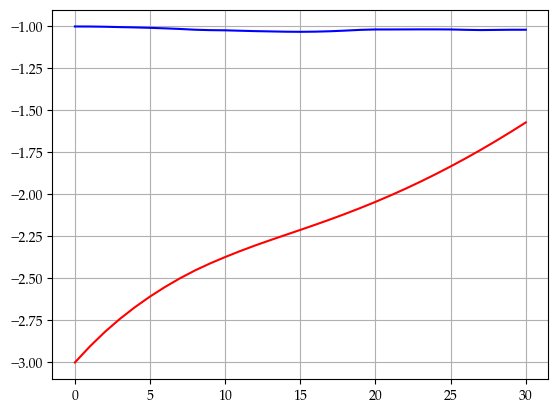

In [319]:
t = np.arange(0,31)
# print((totalMatrix))
plt.plot(t, totalMatrix[0:31, 0], color  = 'r') # Robot controls
plt.plot(t, totalMatrix[0:31, 6], color  = 'b') # Human controls
plt.grid()

## MLP

In [107]:
# feel free to poke around the data
# THIS NEEDS TO BE REVIEWED
train_data = hw1_helper.TrajectoryData("singleData")
test_data = hw1_helper.TrajectoryData("singleData")

history_length = 2 # Number of backward steps considered to train
future_length = 2 # Number of forward considered to train
input_size = 1
output_size = 1

print(len(train_data))

{'history': array([-3.        , -2.8982856 , -2.792798  , -2.6817424 , -2.5647094 ,
       -2.4436467 , -2.3192842 , -2.1920521 , -2.0630364 , -1.9330888 ,
       -1.8026915 , -1.6720301 , -1.5411265 , -1.4099851 , -1.2784723 ,
       -1.1463873 , -1.013822  , -0.88074327, -0.74695617, -0.6124864 ,
       -0.47747806, -0.34212512, -0.20663448, -0.07120909,  0.06396326,
        0.1987171 ], dtype=float32), 'future': array([0.33291253, 0.46643618, 0.5992005 , 0.7311419 , 0.86221844],
      dtype=float32)}
{'history': array([-3.        , -2.8982856 , -2.792798  , -2.6817424 , -2.5647094 ,
       -2.4436467 , -2.3192842 , -2.1920521 , -2.0630364 , -1.9330888 ,
       -1.8026915 , -1.6720301 , -1.5411265 , -1.4099851 , -1.2784723 ,
       -1.1463873 , -1.013822  , -0.88074327, -0.74695617, -0.6124864 ,
       -0.47747806, -0.34212512, -0.20663448, -0.07120909,  0.06396326,
        0.1987171 ], dtype=float32), 'future': array([0.33291253, 0.46643618, 0.5992005 , 0.7311419 , 0.86221844],
    

In [134]:
# Define a simple MLP model
class MLP(torch.nn.Module):
    def __init__(self, history_length, future_length, hidden_size=32):
        super(MLP, self).__init__()
        
        # TODO: construct MLP network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(history_length, 4),
            torch.nn.ReLU(),
            torch.nn.Linear(4, 2),
            torch.nn.ReLU(),
            torch.nn.Linear(2, future_length),
        )

    def forward(self, x):
        return self.model(x)

In [150]:
hidden_size = 3 # 8
history_length = 4 # 10
future_length =4 #5

model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 13 # 30 is OG
batch_size = 4 # 32 is OG
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False) # shuffle=True
print(len(train_dataloader))

7


In [151]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)

Epoch [1/13], Step [0/7], Loss: 0.7112


IndexError: index 5 is out of bounds for dimension 0 with size 5

In [122]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
# print(prediction)
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')

# Visualize prediction on test data
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-11, 5]
ylims = [-2,2]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



IndexError: index 5 is out of bounds for dimension 0 with size 5

Text(0, 0.5, 'y axis')

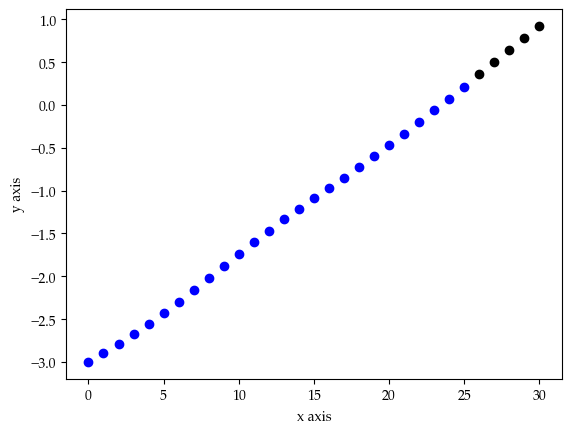

In [116]:
t = jnp.arange(0, len(trainXPosition), 1)
j = jnp.arange(0, len(testXPosition), 1)
plt.scatter(t, trainXPosition, color='b')
plt.scatter(j+len(trainXPosition), testXPosition , color = 'k')
# plt.scatter(j+len(trainXPosition), prediction)
plt.xlabel('x axis')
plt.ylabel('y axis')

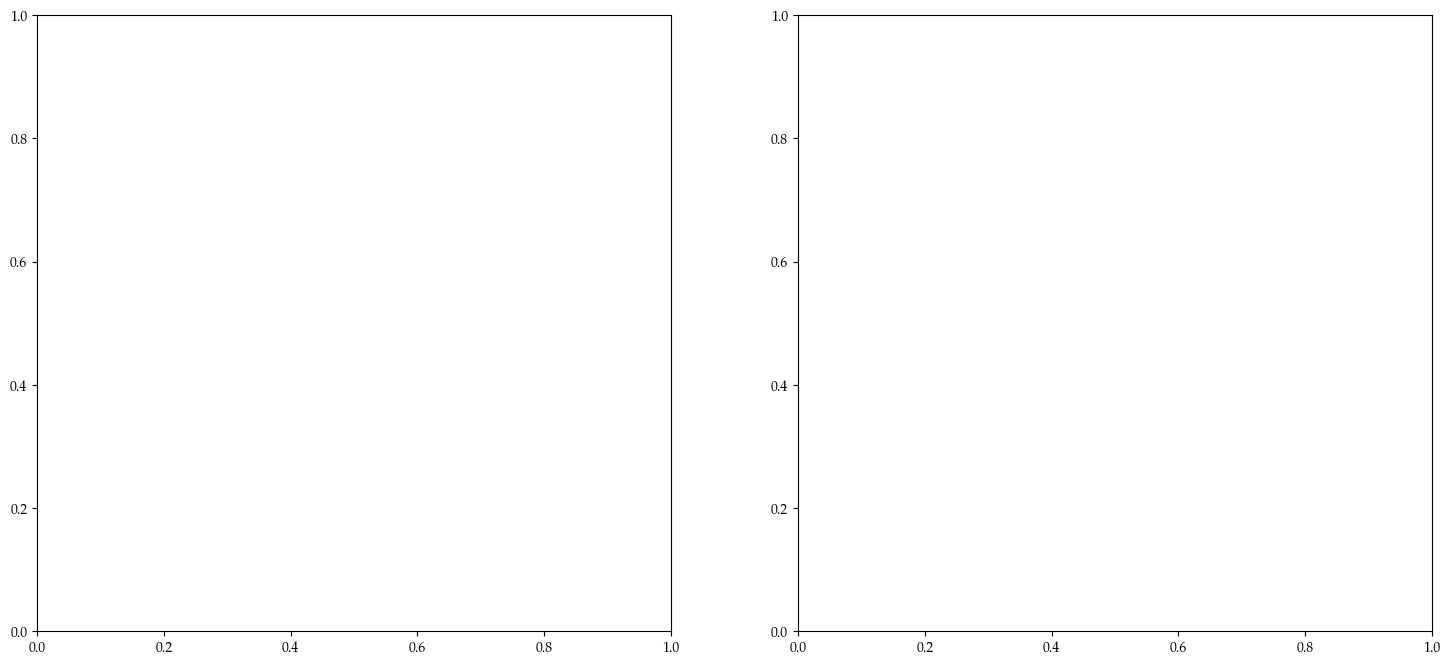

interactive(children=(IntSlider(value=14, description='i', max=29), Output()), _dom_classes=('widget-interact'…

In [52]:
# plotting
@interact(i=(0,num_time_steps-1))
def plot(i):
    fig, axs = plt.subplots(1,2, figsize=(18,8))
    ax = axs[0]
    robot_position = train_data[i]
    circle1 = plt.Circle(robot_position, radius / 2, color='C0', alpha=0.4)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    # ax.plot(human_samples[i,:,:,0].T, human_samples[i,:,:,1].T, "o-", alpha=0.1, markersize=2, color='C1')
    ax.plot(train_data[0], train_data[1], "o-", markersize=3, color='C0')
    ax.plot(train_data[i][0], train_data[i][1], "o-", markersize=3, color='C2', label="planned")
    ax.scatter(train_data[i:i+1], train_data[i:i+1], s=30,  color='C0', label="Robot")
    ax.grid()
    ax.legend()

    ax.set_xlim([-4,4])
    ax.set_ylim([-3, 2])
    ax.axis("equal")

    ax.set_title("heading=%.2f velocity=%.2f"%(robot_trajectory[i,2], robot_trajectory[i,3]))